In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
m = 10

def f(c):
    return np.outer(c, c)

def apply_df_dc(c, h):
    return  np.outer(c, h) + np.outer(h, c)

c0 = np.random.randn(m)
f0 = f(c0)
h = np.random.randn(m)
df_dc_h = apply_df_dc(c0, h)

s = 1e-6
c1 = c0 + s*h
f1 = f(c1)

df_dc_h_diff = (f1 - f0) / s
err_df_dc = np.linalg.norm(df_dc_h_diff - df_dc_h) / np.linalg.norm(df_dc_h_diff)
print('s=', s, ', err_df_dc=', err_df_dc)

s= 1e-06 , err_df_dc= 3.3537135612884913e-07


In [3]:
def G(c):
    return 2.0 * np.dot(c, c) * np.eye(len(c)) + 2.0 * np.outer(c, c)

u = np.random.randn(m)
v = np.random.randn(m)

IP_true = np.sum(apply_df_dc(c0, u) * apply_df_dc(c0, v))

G0 = G(c0)
IP = np.dot(u, np.dot(G0, v))

err_G = np.linalg.norm(IP_true - IP) / np.linalg.norm(IP_true)
print('err_G=', err_G)

err_G= 4.026932865064459e-16


In [4]:
def H(c, p):
    return np.dot(c, c) * np.dot(p, p) + np.dot(c, p)**2


p0 = np.random.randn(m)
H0 = H(c0, p0)
H0_true = 0.5 * np.dot(p0, np.dot(G(c0), p0))

err_hamiltonian = np.linalg.norm(H0 - H0_true) / np.linalg.norm(H0_true)
print('err_hamiltonian=', err_hamiltonian)


err_hamiltonian= 1.9416827249203102e-16


In [5]:
def dH_dc(c, p):
    return 2.0 * c * np.dot(p, p) + 2.0 * p * np.dot(c, p)

c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

h = np.random.randn(m)
dH_dc_h = np.dot(dH_dc(c0, p0), h)

s = 1e-6
c1 = c0 + s*h

H1 = H(c1, p0)
dH_dc_h_diff = (H1 - H0) / s

err_dH_dc = np.linalg.norm(dH_dc_h_diff - dH_dc_h) / np.linalg.norm(dH_dc_h_diff)
print('s=', s, ', err_dH_dc=', err_dH_dc)

s= 1e-06 , err_dH_dc= 5.085867699912155e-07


In [6]:
def dH_dp(c, p):
    return 2.0 * p * np.dot(c, c) + 2.0 * c * np.dot(p, c)

c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

h = np.random.randn(m)
dH_dp_h = np.dot(dH_dp(c0, p0), h)

s = 1e-6
p1 = p0 + s*h

H1 = H(c0, p1)
dH_dp_h_diff = (H1 - H0) / s

err_dH_dp = np.linalg.norm(dH_dp_h_diff - dH_dp_h) / np.linalg.norm(dH_dp_h_diff)
print('s=', s, ', err_dH_dp=', err_dH_dp)

s= 1e-06 , err_dH_dp= 3.887583487414079e-06


T= 1.0 , H0= 0.6809651399254789 , HT= 0.680987629256631


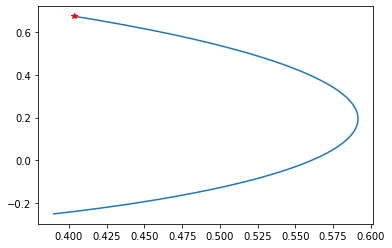

In [7]:
def cdot(c, p):
    return dH_dp(c, p)

def pdot(c, p):
    return -dH_dc(c, p)

def ydot(t, y):
    m = int(len(y)/2)
    c = y[:m]
    p = y[m:]
    return np.concatenate([cdot(c,p), pdot(c,p)])


def geodesic(c0, p0, T, num_pts=None):
    y0 = np.concatenate([c0, p0])
    if num_pts is not None:
        tt = np.linspace(0, T, num_pts)
    else:
        tt = None
    result = solve_ivp(ydot, (0.0, T), y0, t_eval=tt, method='Radau')
    cc = result.y[: len(c0), :]
    pp = result.y[len(c0) :, :]
    return cc, pp

m = 2
c0 = np.random.randn(m)
p0 = np.random.randn(m)
H0 = H(c0, p0)

T = 1.0

cc, pp = geodesic(c0, p0, T, num_pts=1000)

cT = cc[:,-1]
pT = pp[:,-1]

HT = H(cT, pT)
print('T=', T, ', H0=', H0, ', HT=', HT)

plt.plot(cc[0,:], cc[1,:])
plt.plot(cT[0], cT[1], '*r') # final point

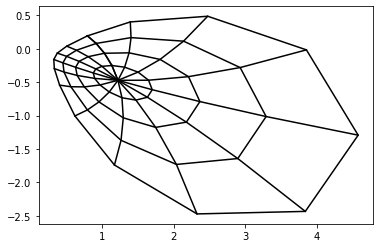

In [8]:
num_radii = 5
num_theta = 15

m = 2
c0 = np.random.randn(m)

thetas = np.linspace(0,2*np.pi, num_theta)
all_p0 = [np.array([np.sin(theta), np.cos(theta)]) for theta in list(thetas)]


T = 0.25

all_cc = np.zeros((m, num_radii, num_theta))
for ii in range(num_theta):
    p0 = all_p0[ii]
    cc, pp = geodesic(c0, p0, T, num_pts=num_radii)
    all_cc[:,:,ii] = cc

for ii in range(num_theta):
    plt.plot(all_cc[0,:,ii], all_cc[1,:,ii], 'k')
    
for jj in range(num_radii):
    plt.plot(all_cc[0,jj,:], all_cc[1,jj,:], 'k')

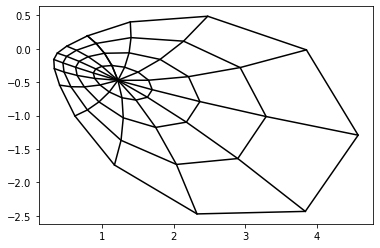

In [9]:
def exp_map(c0, p0, t):
    result = geodesic(c0, p0, t, num_pts=None)
    return result[0][:,-1], result[1][:,-1]

tt = np.linspace(0, T, num_radii)

all_cc = np.zeros((m, num_radii, num_theta))
for ii in range(num_theta):
    for jj in range(num_radii):
        p0 = all_p0[ii]
        all_cc[:,jj,ii] = exp_map(c0, all_p0[ii], tt[jj])[0]

for ii in range(num_theta):
    plt.plot(all_cc[0,:,ii], all_cc[1,:,ii], 'k')
    
for jj in range(num_radii):
    plt.plot(all_cc[0,jj,:], all_cc[1,jj,:], 'k')

In [10]:
def cdotdot(c, p):
    cd = cdot(c, p)
    pd = pdot(c, p)
    return (2.0 * pd * np.dot(c,  c) +
            4.0 * p  * np.dot(cd, c) +
            2.0 * cd * np.dot(p,  c) +
            2.0 * c  * np.dot(pd, c) +
            2.0 * c  * np.dot(p,  cd))

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cd0 = cdot(c0, p0)
cdd0 = cdotdot(c0, p0)

s = 1e-7
c1, p1 = exp_map(c0, p0, s)
cd1 = cdot(c1, p1)

cdd0_diff = (cd1 - cd0) / s
err_cdotdot = np.linalg.norm(cdd0_diff - cdd0) / np.linalg.norm(cdd0_diff)
print('s=', s, ', err_cdotdot=', err_cdotdot)

s= 1e-07 , err_cdotdot= 1.37350736299912e-06


In [11]:
def apply_dcdot_dp(c, p, h):
    return 2.0 * h * np.dot(c, c) + 2.0 * c * np.dot(h, c) # equals cdot(c,h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cd0 = cdot(c0, p0)
h = np.random.randn(m)
dcdot_dp_h = apply_dcdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
cd1 = cdot(c0, p1)

dcdot_dp_h_diff = (cd1 - cd0) / s

err_dcdot_dp_h = np.linalg.norm(dcdot_dp_h_diff - dcdot_dp_h) / np.linalg.norm(dcdot_dp_h_diff)
print('s=', s, ', err_dcdot_dp_h=', err_dcdot_dp_h)

s= 1e-06 , err_dcdot_dp_h= 8.732686978735108e-11


In [12]:
def apply_dpdot_dp(c, p, h):
    return -4.0 * c * np.dot(h, p) - 2.0 * h * np.dot(c, p) - 2.0 * p * np.dot(c, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
pd0 = pdot(c0, p0)
h = np.random.randn(m)
dpdot_dp_h = apply_dpdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
pd1 = pdot(c0, p1)

dpdot_dp_h_diff = (pd1 - pd0) / s

err_dpdot_dp_h = np.linalg.norm(dpdot_dp_h_diff - dpdot_dp_h) / np.linalg.norm(dpdot_dp_h_diff)
print('s=', s, ', err_dpdot_dp_h=', err_dpdot_dp_h)

s= 1e-06 , err_dpdot_dp_h= 3.6540845796650644e-06


In [13]:
apply_dcdot_dp_T = apply_dcdot_dp

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dcdot_dp_T = np.dot(apply_dcdot_dp(c0, p0, u), v) - np.dot(u, apply_dcdot_dp_T(c0, p0, v))
print('err_apply_dcdot_dp_T=', err_apply_dcdot_dp_T)

err_apply_dcdot_dp_T= -7.105427357601002e-15


In [14]:
def apply_dpdot_dp_T(c, p, h):
    return -4.0 * p * np.dot(h, c) - 2.0 * h * np.dot(c, p) - 2.0 * c * np.dot(p, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dpdot_dp_T = np.dot(apply_dpdot_dp(c0, p0, u), v) - np.dot(u, apply_dpdot_dp_T(c0, p0, v))
print('err_apply_dpdot_dp_T=', err_apply_dpdot_dp_T)

err_apply_dpdot_dp_T= 7.105427357601002e-15


In [15]:
def apply_dcdotdot_dp(c, p, h):
    cd = cdot(c, p)
    pd = pdot(c, p)
    dcd = apply_dcdot_dp(c, p, h)
    dpd = apply_dpdot_dp(c, p, h)
    t1  = 2.0 * dpd * np.dot(c,   c)
    t2a = 4.0 * h   * np.dot(cd,  c) 
    t2b = 4.0 * p   * np.dot(dcd, c)
    t3a = 2.0 * dcd * np.dot(p,   c)
    t3b = 2.0 * cd  * np.dot(h,   c)
    t4  = 2.0 * c   * np.dot(dpd, c)
    t5a = 2.0 * c   * np.dot(h,   cd)
    t5b = 2.0 * c   * np.dot(p,   dcd)
    return t1 + t2a + t2b + t3a + t3b + t4 + t5a + t5b

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
cdd0 = cdotdot(c0, p0)
h = np.random.randn(m)
dcdotdot_dp_h = apply_dcdotdot_dp(c0, p0, h)

s = 1e-6
p1 = p0 + s*h
cdd1 = cdotdot(c0, p1)

dcdotdot_dp_h_diff = (cdd1 - cdd0) / s

err_dcdotdot_dp_h = np.linalg.norm(dcdotdot_dp_h_diff - dcdotdot_dp_h) / np.linalg.norm(dcdotdot_dp_h_diff)
print('s=', s, ', err_dcdotdot_dp_h=', err_dcdotdot_dp_h)

s= 1e-06 , err_dcdotdot_dp_h= 4.579005358851873e-07


In [16]:
def apply_dcdotdot_dp_T(c, p, h):
    cd = cdot(c, p)
    pd = pdot(c, p)
    p_cph = apply_dpdot_dp_T(c, p, h)
    c_cpc = apply_dcdot_dp_T(c, p, c)
    c_cph = apply_dcdot_dp_T(c, p, h)
    p_cpc = apply_dpdot_dp_T(c, p, c)
    c_cpp = apply_dcdot_dp_T(c, p, p)
    t1  = 2.0 * p_cph * np.dot(c,  c)
    t2a = 4.0 * h     * np.dot(cd, c) 
    t2b = 4.0 * c_cpc * np.dot(p,  h)
    t3a = 2.0 * c_cph * np.dot(p,  c)
    t3b = 2.0 * c     * np.dot(cd, h)
    t4  = 2.0 * p_cpc * np.dot(c,  h)
    t5a = 2.0 * cd    * np.dot(c,  h)
    t5b = 2.0 * c_cpp * np.dot(c,  h)
    return t1 + t2a + t2b + t3a + t3b + t4 + t5a + t5b
    
m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dcdotdot_dp_T = np.dot(apply_dcdotdot_dp(c0, p0, u), v) - np.dot(u, apply_dcdotdot_dp_T(c0, p0, v))
print('err_apply_dcdotdot_dp_T=', err_apply_dcdotdot_dp_T)

err_apply_dcdotdot_dp_T= 2.2737367544323206e-13


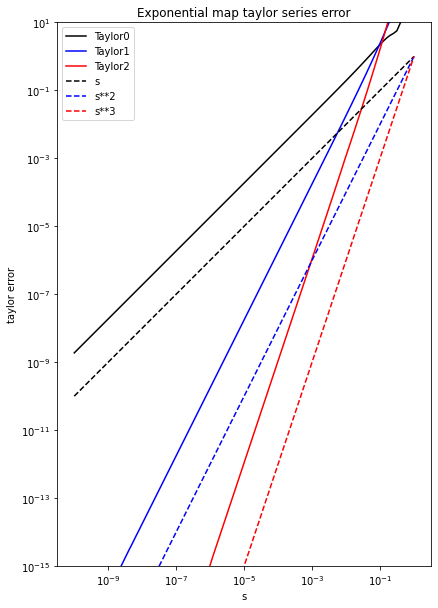

In [17]:
def exp_map_taylor0(c, p, t):
    return c

def exp_map_taylor1(c, p, t):
    return c + t * cdot(c,p)

def exp_map_taylor2(c, p, t):
    return c + t * cdot(c,p) + (t**2 / 2.0) * cdotdot(c,p)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)

ss = np.logspace(-10, 0, 100)
all_err_taylor0 = np.zeros(len(ss))
all_err_taylor1 = np.zeros(len(ss))
all_err_taylor2 = np.zeros(len(ss))
for ii in range(len(ss)):
    s = ss[ii]
    es_true = exp_map(c0, p0, s)[0]
    es0 = exp_map_taylor0(c0, p0, s)
    es1 = exp_map_taylor1(c0, p0, s)
    es2 = exp_map_taylor2(c0, p0, s)

    err_taylor0 = np.linalg.norm(es0 - es_true) / np.linalg.norm(es_true)
    err_taylor1 = np.linalg.norm(es1 - es_true) / np.linalg.norm(es_true)
    err_taylor2 = np.linalg.norm(es2 - es_true) / np.linalg.norm(es_true)
    
    all_err_taylor0[ii] = err_taylor0
    all_err_taylor1[ii] = err_taylor1
    all_err_taylor2[ii] = err_taylor2
    
#     print('s=', s, ', err_taylor0=', err_taylor0, ', err_taylor1=', err_taylor1, ', err_taylor2=', err_taylor2)

plt.figure(figsize=(10,10))
plt.loglog(ss, all_err_taylor0, 'k')
plt.loglog(ss, all_err_taylor1, 'b')
plt.loglog(ss, all_err_taylor2, 'r')
plt.loglog(ss, ss, '--k')
plt.loglog(ss, ss**2, '--b')
plt.loglog(ss, ss**3, '--r')
plt.ylim(1e-15, 1e1)
plt.title('Exponential map taylor series error')
plt.xlabel('s')
plt.ylabel('taylor error')
plt.legend(['Taylor0', 'Taylor1', 'Taylor2', 's', 's**2', 's**3'])
plt.gca().set_aspect('equal')

In [18]:
def apply_dexp_map_taylor0_dp(c, p, t, h): # apply to h
    return np.zeros(c.shape)

def apply_dexp_map_taylor1_dp(c, p, t, h): # apply to h
    return t * apply_dcdot_dp(c, p, h)

def apply_dexp_map_taylor2_dp(c, p, t, h): # apply to h
    return t * apply_dcdot_dp(c, p, h) + (t**2 / 2.0) * apply_dcdotdot_dp(c, p, h)


m = 10
c0 = np.random.randn(m)
# p0 = np.random.randn(m)
p0 = np.zeros(m)
T = 0.7
eT0_0 = exp_map(c0, p0, T)[0]
eT1_0 = exp_map(c0, p0, T)[0]
eT2_0 = exp_map(c0, p0, T)[0]
# eT0_0 = exp_map_taylor0(c0, p0, T)
# eT1_0 = exp_map_taylor1(c0, p0, T)
# eT2_0 = exp_map_taylor2(c0, p0, T)

h = np.random.randn(m)
deT0_dp = apply_dexp_map_taylor0_dp(c0, p0, T, h)
deT1_dp = apply_dexp_map_taylor1_dp(c0, p0, T, h)
deT2_dp = apply_dexp_map_taylor2_dp(c0, p0, T, h)

s = 1e-7
p1 = p0 + s * h
eT0_1 = exp_map(c0, p1, T)[0]
eT1_1 = exp_map(c0, p1, T)[0]
eT2_1 = exp_map(c0, p1, T)[0]
# eT0_1 = exp_map_taylor0(c0, p1, T)
# eT1_1 = exp_map_taylor1(c0, p1, T)
# eT2_1 = exp_map_taylor2(c0, p1, T)


deT0_dp_diff = (eT0_1 - eT0_0) / s
deT1_dp_diff = (eT1_1 - eT1_0) / s
deT2_dp_diff = (eT2_1 - eT2_0) / s

err_deT0_dp = np.linalg.norm(deT0_dp_diff - deT0_dp) # should be exact zero
err_deT1_dp = np.linalg.norm(deT1_dp_diff - deT1_dp) / np.linalg.norm(deT1_dp_diff)
err_deT2_dp = np.linalg.norm(deT2_dp_diff - deT2_dp) / np.linalg.norm(deT2_dp_diff)

print('s=', s, ', err_deT0_dp=', err_deT0_dp)
print('s=', s, ', err_deT1_dp=', err_deT1_dp)
print('s=', s, ', err_deT2_dp=', err_deT2_dp)

s= 1e-07 , err_deT0_dp= 27.364193213957748
s= 1e-07 , err_deT1_dp= 5.707896585444431e-07
s= 1e-07 , err_deT2_dp= 5.707896585444431e-07


In [19]:
def apply_dexp_map_taylor0_dp_T(c, p, t, h): # apply to h
    return np.zeros(c.shape)

def apply_dexp_map_taylor1_dp_T(c, p, t, h): # apply to h
    return t * apply_dcdot_dp_T(c, p, h)

def apply_dexp_map_taylor2_dp_T(c, p, t, h): # apply to h
    return t * apply_dcdot_dp_T(c, p, h) + (t**2 / 2.0) * apply_dcdotdot_dp_T(c, p, h)

m = 10
c0 = np.random.randn(m)
p0 = np.random.randn(m)
T=0.7

u = np.random.randn(m)
v = np.random.randn(m)

err_apply_dexp_map_taylor0_dp_T = (np.dot(apply_dexp_map_taylor0_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor0_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor0_dp_T=', err_apply_dexp_map_taylor0_dp_T)

err_apply_dexp_map_taylor1_dp_T = (np.dot(apply_dexp_map_taylor1_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor1_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor1_dp_T=', err_apply_dexp_map_taylor1_dp_T)

err_apply_dexp_map_taylor2_dp_T = (np.dot(apply_dexp_map_taylor2_dp(c0, p0, T, u), v)
                                 - np.dot(u, apply_dexp_map_taylor2_dp_T(c0, p0,T,  v)))
print('err_apply_dexp_map_taylor2_dp_T=', err_apply_dexp_map_taylor2_dp_T)

err_apply_dexp_map_taylor0_dp_T= 0.0
err_apply_dexp_map_taylor1_dp_T= -3.552713678800501e-15
err_apply_dexp_map_taylor2_dp_T= 2.2737367544323206e-13


In [151]:
N = 100 # number of rows/cols of basis matrices
m = 7 # number of basis matrices
r = 2 # number of probing vectors

BB = [np.random.randn(N,N) for _ in range(m)] # basis matrices
def apply_Bk(x, k):
    return np.dot(BB[k], x)

def apply_Bk_T(x, k):
    return np.dot(BB[k].T, x)

def apply_BB(X, c):
    return np.array([c[k] * apply_Bk(X, k) for k in range(m)])

def apply_BB_adjc(X, Z):
    return np.array([np.sum(X * apply_Bk_T(Z, k)) for k in range(m)])

X = np.random.randn(N,r)
Z = np.random.randn(N,r)
c = np.random.randn(m)

err_apply_BB_adjc = np.sum(apply_BB(X, c) * Z) - np.sum(c * apply_BB_adjc(X, Z))
print('err_apply_BB_adjc=', err_apply_BB_adjc)

def apply_BB_T(X, c):
    return np.array([c[k] * apply_Bk_T(X, k) for k in range(m)])

def apply_BB_T_adjc(X, Z):
    return np.array([np.sum(X * apply_Bk(Z, k)) for k in range(m)])

X = np.random.randn(N,r)
Z = np.random.randn(N,r)
c = np.random.randn(m)

err_apply_BB_T_adjc = np.sum(apply_BB_T(X, c) * Z) - np.sum(c * apply_BB_T_adjc(X, Z))
print('err_apply_BB_T_adjc=', err_apply_BB_T_adjc)


def apply_sqrtA(X, c):
    return np.sum(apply_BB(X, c), axis=0)

def apply_sqrtA_adjc(X, Z):
    return apply_BB_adjc(X, Z)

X = np.random.randn(N,r)
Z = np.random.randn(N,r)
c = np.random.randn(m)

err_apply_sqrtA_adjc = np.sum(apply_sqrtA(X, c) * Z) - np.sum(c * apply_sqrtA_adjc(X, Z))
print('err_apply_sqrtA_adjc=', err_apply_sqrtA_adjc)


def apply_sqrtA_T(x, c):
    return np.sum(apply_BB_T(x, c), axis=0)

def apply_sqrtA_T_adjc(X, Z):
    return apply_BB_T_adjc(X, Z)

X = np.random.randn(N,r)
Z = np.random.randn(N,r)
c = np.random.randn(m)

err_apply_sqrtA_T_adjc = np.sum(apply_sqrtA_T(X, c) * Z) - np.sum(c * apply_sqrtA_T_adjc(X, Z))
print('err_apply_sqrtA_T_adjc=', err_apply_sqrtA_T_adjc)

apply_A = lambda x, c: apply_sqrtA_T(apply_sqrtA(x, c), c)


c_true = np.random.randn(m)

sqrtA_true = np.zeros((N,N))
for ii in range(m):
    sqrtA_true += c_true[ii] * BB[ii]

x = np.random.randn(N)
y_true = np.dot(sqrtA_true, x)
y = apply_sqrtA(x, c_true)
err_apply_sqrtA = np.linalg.norm(y_true - y) / np.linalg.norm(y_true)
print('err_apply_sqrtA=', err_apply_sqrtA)


x = np.random.randn(N)
y_true = np.dot(sqrtA_true.T, x)
y = apply_sqrtA_T(x, c_true)
err_apply_sqrtA_T = np.linalg.norm(y_true - y) / np.linalg.norm(y_true)
print('err_apply_sqrtA_T=', err_apply_sqrtA_T)

    
A_true = np.dot(sqrtA_true.T, sqrtA_true)
    
X = np.random.randn(N, r)
Y1 = np.dot(A_true, X)
Y2 = apply_A(X, c_true)
err_apply_A = np.linalg.norm(Y1 - Y2) / np.linalg.norm(Y2)
print('err_apply_A=', err_apply_A)

err_apply_BB_adjc= -1.5631940186722204e-13
err_apply_BB_T_adjc= 3.694822225952521e-13
err_apply_sqrtA_adjc= 5.684341886080802e-14
err_apply_sqrtA_T_adjc= -5.684341886080802e-14
err_apply_sqrtA= 4.460464135265767e-16
err_apply_sqrtA_T= 4.771585782393967e-16
err_apply_A= 6.309313738336913e-16


In [152]:
Omega = np.random.randn(N,r)
Y = apply_A(Omega, c_true)

BB_Omega = np.array([apply_Bk(Omega, k) for k in range(m)])
sqrtA_true_Omega = np.sum([c_true[k] * BB_Omega[k,:,:] for k in range(m)], axis=0)
err_sqrtA_true_Omega = np.linalg.norm(apply_sqrtA(Omega, c_true) - sqrtA_true_Omega)
print('err_sqrtA_true_Omega=', err_sqrtA_true_Omega)

err_sqrtA_true_Omega= 0.0


In [154]:
# fwd = lambda c: apply_A(Omega, c)
fwd = lambda c: apply_sqrtA_T(apply_sqrtA(Omega, c), c)

apply_Jac = lambda c, h: apply_sqrtA_T(apply_sqrtA(Omega, c), h) + apply_sqrtA_T(apply_sqrtA(Omega, h), c) # good

# def apply_Jac(c, h):
#     R1a = apply_BB(Omega, h)
#     R1b = np.sum(R1a, axis=0)
#     R1c = apply_BB_T(R1b, c)
#     R1d = np.sum(R1c, axis=0)
    
#     R2a = apply_BB(Omega, c)
#     R2b = np.sum(R2a, axis=0)
#     R2c = apply_BB_T(R2b, h)
#     R2d = np.sum(R2c, axis=0)
    
#     return R1d + R2d


c0 = np.random.randn(m)
f0 = fwd(c0)

h = np.random.randn(m)
df0 = apply_Jac(c0, h)

s = 1e-7
c1 = c0 + s*h
f1 = fwd(c1)

df0_diff = (f1 - f0) / s
err_Jac = np.linalg.norm(df0_diff - df0) / np.linalg.norm(df0_diff)
print('s=', s, ', err_Jac=', err_Jac)

s= 1e-07 , err_Jac= 9.564747533484047e-08


In [160]:
apply_Jac = lambda c, h: apply_sqrtA_T(apply_sqrtA(Omega, c), h) + apply_sqrtA_T(apply_sqrtA(Omega, h), c)

def apply_Jac_T(c, H):
    t1 = apply_sqrtA_T_adjc(apply_sqrtA(Omega, c), H)
    t2 = apply_sqrtA_adjc(Omega, apply_sqrtA(H, c))
    return t1 + t2

c = np.random.randn(m)

h = np.random.randn(m)
H = np.random.randn(N,r)

err_apply_Jac_T = np.sum(apply_Jac(c,h) * H) - np.sum(h * apply_Jac_T(c,H))
print('err_apply_Jac_T=', err_apply_Jac_T)

err_apply_Jac_T= -3.637978807091713e-12


In [162]:
apply_Jac_T(c,H)

array([-8594.80151423,  2209.49444418,  -828.34557448,  7353.94504072,
       -8317.50412395, -3003.01640658, -6588.60934167])

In [163]:
def misfit(c):
    return 0.5 * np.linalg.norm(Y - fwd(c))**2

misfit_true = misfit(c_true)
print('misfit_true=', misfit_true)

c0 = np.random.randn(m)
misfit0 = misfit(c0)
print('misfit0=', misfit0)

misfit_true= 0.0
misfit0= 161981293.5192331


In [164]:
def gradient(c):
    return -apply_Jac_T(c, Y - fwd(c))

c0 = np.random.randn(m)
J0 = misfit(c0)
G0 = gradient(c0)

h = np.random.randn(m)
dJ = np.dot(h, G0)

s = 1e-7
c1 = c0 + s*h
J1 = misfit(c1)

dJ_diff = (J1 - J0) / s
err_grad = np.linalg.norm(dJ_diff - dJ) / np.linalg.norm(dJ_diff)
print('s=', s, ', err_grad=', err_grad)

s= 1e-07 , err_grad= 2.4139669694240807e-07


In [165]:
G0

array([-14955716.40548722,  -9175271.66693515,   5069313.68090742,
        -6448473.40586659,   4692121.90341706,  13556358.72594203,
         5311569.94668794])

In [96]:
gradient(c_true + 1e-6*np.random.randn(m))

array([14.48824206, 14.48824206, 14.48824206, 14.48824206, 14.48824206,
       14.48824206, 14.48824206])

In [71]:
J0

14415.351450389217

In [74]:
G0

array([-4.58897143e+08, -4.58897143e+08, -4.58897143e+08, -4.58897143e+08,
       -4.58897143e+08, -4.58897143e+08, -4.58897143e+08])

In [20]:
deT0_dp_diff

array([  6.21709433, -17.59043425, -10.55198916,  14.93224031,
        -5.35041907,   2.66186984,   2.05260391,   5.50357342,
       -26.77293872, -44.7550824 ])

In [21]:
deT0_dp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
err_taylor0 = np.linalg.norm(es0 - es_true) / np.linalg.norm(es_true)

In [23]:
dcdot_dp_h_diff

array([30.72683104,  4.83708814, 31.14437908, 12.70310413, 20.65720759,
       11.50276548, -1.57899082, 16.97687577, -6.32930321,  9.86899865])

In [24]:
cdd0_diff

array([ 150.93112417,   -0.50971249,  203.84313268, -277.44127409,
        -11.1048322 ,  182.73504367, -270.44446892,   39.62452274,
          7.87887754,    3.95852442])

In [25]:
cdd0

array([  298.75575814,   237.89183422,   567.86585145,  -155.89609383,
        -820.62665   ,   431.93226695, -1241.26619036,  -730.74148653,
        -369.79267667, -1813.65430475])

In [26]:
cc100[:,-1]

NameError: name 'cc100' is not defined

In [ ]:
plt.plot(cc[0,:], cc[1,:])

In [ ]:
cc